In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [8]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [9]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [11]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        #aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1 # unrated

        # Sampling
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            if done is True:
                break
        
        # Rating
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
        # Training
        batch = memory.buffer
        for idx in range(memory_size// batch_size):
        # while True:
        #     idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates == np.max(rates)]
            actions = actions[rates == np.max(rates)]
            next_states = next_states[rates == np.max(rates)]
            #rewards = rewards[rates == np.max(rates)]
            dones = dones[rates == np.max(rates)]
            rates = rates[rates == np.max(rates)]
            #if np.count_nonzero(dones)==1 and len(dones) > 1 and np.max(rates) > 0:
            if len(dones) > 1:
                aloss, _ = sess.run([model.a_loss, model.a_opt],
                                    feed_dict = {model.states: states, 
                                                model.actions: actions,
                                                model.next_states: next_states,
                                                #model.rewards: rewards,
                                                model.dones: dones,
                                                model.rates: rates})
                dloss, _ = sess.run([model.d_loss, model.d_opt],
                                      feed_dict = {model.states: states, 
                                                   model.actions: actions,
                                                   model.next_states: next_states,
                                                   #model.rewards: rewards,
                                                   model.dones: dones,
                                                   model.rates: rates})
                aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                     feed_dict = {model.states: states, 
                                                  model.actions: actions,
                                                  model.next_states: next_states,
                                                  #model.rewards: rewards,
                                                  model.dones: dones,
                                                  model.rates: rates})

        # Printing
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss)),
              'dloss:{:.4f}'.format(np.mean(dloss)),
              'aloss2:{:.4f}'.format(np.mean(aloss2)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:1.3914 dloss:2.0881 aloss2:1.3718 exploreP:0.9986
Episode:1 meanR:19.5000 R:25.0000 rate:0.0500 aloss:1.3943 dloss:2.0373 aloss2:1.4006 exploreP:0.9961
Episode:2 meanR:21.0000 R:24.0000 rate:0.0480 aloss:1.3971 dloss:1.9879 aloss2:1.4298 exploreP:0.9938
Episode:3 meanR:20.7500 R:20.0000 rate:0.0400 aloss:1.4004 dloss:1.9375 aloss2:1.4605 exploreP:0.9918
Episode:4 meanR:19.6000 R:15.0000 rate:0.0300 aloss:1.4019 dloss:1.8837 aloss2:1.4958 exploreP:0.9903
Episode:5 meanR:21.5000 R:31.0000 rate:0.0620 aloss:1.4023 dloss:1.8270 aloss2:1.5353 exploreP:0.9873
Episode:6 meanR:20.1429 R:12.0000 rate:0.0240 aloss:1.4012 dloss:1.7683 aloss2:1.5788 exploreP:0.9861
Episode:7 meanR:20.0000 R:19.0000 rate:0.0380 aloss:1.3989 dloss:1.7075 aloss2:1.6279 exploreP:0.9843
Episode:8 meanR:20.1111 R:21.0000 rate:0.0420 aloss:1.3954 dloss:1.6449 aloss2:1.6829 exploreP:0.9822
Episode:9 meanR:21.6000 R:35.0000 rate:0.0700 aloss:1.3912 dloss:1.5809 aloss2:1.7

Episode:80 meanR:26.9383 R:19.0000 rate:0.0380 aloss:1.3480 dloss:0.5488 aloss2:6.2804 exploreP:0.8059
Episode:81 meanR:26.9634 R:29.0000 rate:0.0580 aloss:1.3436 dloss:0.5485 aloss2:6.2955 exploreP:0.8036
Episode:82 meanR:26.7952 R:13.0000 rate:0.0260 aloss:1.3401 dloss:0.5488 aloss2:6.2997 exploreP:0.8026
Episode:83 meanR:26.7381 R:22.0000 rate:0.0440 aloss:1.3438 dloss:0.5494 aloss2:6.2986 exploreP:0.8008
Episode:84 meanR:26.7765 R:30.0000 rate:0.0600 aloss:1.3514 dloss:0.5491 aloss2:6.3223 exploreP:0.7985
Episode:85 meanR:26.6860 R:19.0000 rate:0.0380 aloss:1.3564 dloss:0.5479 aloss2:6.3548 exploreP:0.7970
Episode:86 meanR:26.5977 R:19.0000 rate:0.0380 aloss:1.3560 dloss:0.5466 aloss2:6.3609 exploreP:0.7955
Episode:87 meanR:26.8636 R:50.0000 rate:0.1000 aloss:1.3484 dloss:0.5461 aloss2:6.3424 exploreP:0.7916
Episode:88 meanR:26.9888 R:38.0000 rate:0.0760 aloss:1.3393 dloss:0.5471 aloss2:6.2905 exploreP:0.7886
Episode:89 meanR:26.9556 R:24.0000 rate:0.0480 aloss:1.3375 dloss:0.5488 

Episode:159 meanR:46.6500 R:69.0000 rate:0.1380 aloss:1.4260 dloss:1.1075 aloss2:5.9487 exploreP:0.5474
Episode:160 meanR:46.4100 R:25.0000 rate:0.0500 aloss:1.4214 dloss:1.1072 aloss2:5.9614 exploreP:0.5461
Episode:161 meanR:47.0100 R:79.0000 rate:0.1580 aloss:1.4042 dloss:1.1068 aloss2:5.9765 exploreP:0.5419
Episode:162 meanR:47.5300 R:95.0000 rate:0.1900 aloss:1.3857 dloss:1.1052 aloss2:5.9708 exploreP:0.5368
Episode:163 meanR:48.4500 R:130.0000 rate:0.2600 aloss:1.3789 dloss:1.1041 aloss2:5.9591 exploreP:0.5300
Episode:164 meanR:49.0100 R:77.0000 rate:0.1540 aloss:1.3799 dloss:1.1033 aloss2:5.9454 exploreP:0.5261
Episode:165 meanR:49.1600 R:33.0000 rate:0.0660 aloss:1.3842 dloss:1.1044 aloss2:5.9548 exploreP:0.5244
Episode:166 meanR:49.0100 R:18.0000 rate:0.0360 aloss:1.3889 dloss:1.1048 aloss2:5.9572 exploreP:0.5234
Episode:167 meanR:49.5600 R:67.0000 rate:0.1340 aloss:1.4513 dloss:1.1008 aloss2:5.8344 exploreP:0.5200
Episode:168 meanR:50.2000 R:82.0000 rate:0.1640 aloss:1.8569 dl

Episode:238 meanR:76.2700 R:46.0000 rate:0.0920 aloss:1.2699 dloss:0.9455 aloss2:6.0493 exploreP:0.2925
Episode:239 meanR:76.3100 R:50.0000 rate:0.1000 aloss:1.2715 dloss:0.9457 aloss2:6.0533 exploreP:0.2911
Episode:240 meanR:77.1200 R:120.0000 rate:0.2400 aloss:1.2707 dloss:0.9458 aloss2:6.0550 exploreP:0.2877
Episode:241 meanR:77.2600 R:77.0000 rate:0.1540 aloss:1.2686 dloss:0.9460 aloss2:6.0557 exploreP:0.2856
Episode:242 meanR:77.2900 R:38.0000 rate:0.0760 aloss:1.2671 dloss:0.9464 aloss2:6.0597 exploreP:0.2845
Episode:243 meanR:76.8300 R:44.0000 rate:0.0880 aloss:1.2670 dloss:0.9460 aloss2:6.0523 exploreP:0.2833
Episode:244 meanR:77.1000 R:40.0000 rate:0.0800 aloss:1.2676 dloss:0.9453 aloss2:6.0405 exploreP:0.2822
Episode:245 meanR:77.3500 R:56.0000 rate:0.1120 aloss:1.2646 dloss:0.9445 aloss2:6.0257 exploreP:0.2807
Episode:246 meanR:77.2200 R:47.0000 rate:0.0940 aloss:1.2302 dloss:0.9445 aloss2:5.9691 exploreP:0.2795
Episode:247 meanR:77.5200 R:81.0000 rate:0.1620 aloss:1.2345 dl

Episode:317 meanR:71.6000 R:69.0000 rate:0.1380 aloss:1.1953 dloss:0.9958 aloss2:5.9091 exploreP:0.1691
Episode:318 meanR:71.8900 R:84.0000 rate:0.1680 aloss:1.1956 dloss:0.9953 aloss2:5.9007 exploreP:0.1678
Episode:319 meanR:72.2100 R:100.0000 rate:0.2000 aloss:1.1946 dloss:0.9946 aloss2:5.8901 exploreP:0.1662
Episode:320 meanR:72.5800 R:95.0000 rate:0.1900 aloss:1.1936 dloss:0.9947 aloss2:5.8927 exploreP:0.1648
Episode:321 meanR:72.9700 R:120.0000 rate:0.2400 aloss:1.1930 dloss:0.9953 aloss2:5.9012 exploreP:0.1629
Episode:322 meanR:73.1600 R:85.0000 rate:0.1700 aloss:1.1910 dloss:0.9958 aloss2:5.9092 exploreP:0.1616
Episode:323 meanR:72.9800 R:66.0000 rate:0.1320 aloss:1.1895 dloss:0.9963 aloss2:5.9169 exploreP:0.1606
Episode:324 meanR:73.7500 R:136.0000 rate:0.2720 aloss:1.1905 dloss:0.9953 aloss2:5.8995 exploreP:0.1586
Episode:325 meanR:73.8500 R:68.0000 rate:0.1360 aloss:1.1921 dloss:0.9944 aloss2:5.8850 exploreP:0.1576
Episode:326 meanR:74.2600 R:97.0000 rate:0.1940 aloss:1.1798 

Episode:395 meanR:191.3400 R:500.0000 rate:1.0000 aloss:1.1542 dloss:2.6681 aloss2:4.9703 exploreP:0.0380
Episode:396 meanR:195.2800 R:472.0000 rate:0.9440 aloss:1.1540 dloss:2.6563 aloss2:4.9404 exploreP:0.0367
Episode:397 meanR:196.9800 R:217.0000 rate:0.4340 aloss:1.1506 dloss:2.6453 aloss2:4.9066 exploreP:0.0361
Episode:398 meanR:201.1900 R:500.0000 rate:1.0000 aloss:1.1455 dloss:2.6338 aloss2:4.8815 exploreP:0.0348
Episode:399 meanR:205.2300 R:464.0000 rate:0.9280 aloss:1.1506 dloss:2.6198 aloss2:4.8466 exploreP:0.0337
Episode:400 meanR:209.3500 R:480.0000 rate:0.9600 aloss:1.1469 dloss:2.6113 aloss2:4.7850 exploreP:0.0326
Episode:401 meanR:210.7100 R:181.0000 rate:0.3620 aloss:1.1662 dloss:2.4205 aloss2:4.5984 exploreP:0.0322
Episode:402 meanR:211.2300 R:182.0000 rate:0.3640 aloss:1.1641 dloss:2.4135 aloss2:4.5744 exploreP:0.0318
Episode:403 meanR:212.4100 R:207.0000 rate:0.4140 aloss:1.1647 dloss:2.3991 aloss2:4.5327 exploreP:0.0314
Episode:404 meanR:213.9500 R:283.0000 rate:0.5

Episode:473 meanR:347.4700 R:231.0000 rate:0.4620 aloss:1.1259 dloss:1.9562 aloss2:3.5141 exploreP:0.0121
Episode:474 meanR:347.4700 R:500.0000 rate:1.0000 aloss:1.0719 dloss:2.1646 aloss2:3.5927 exploreP:0.0120
Episode:475 meanR:346.2500 R:378.0000 rate:0.7560 aloss:1.0728 dloss:2.1616 aloss2:3.5836 exploreP:0.0119
Episode:476 meanR:345.5500 R:272.0000 rate:0.5440 aloss:1.0671 dloss:2.1549 aloss2:3.5644 exploreP:0.0119
Episode:477 meanR:342.8500 R:230.0000 rate:0.4600 aloss:1.1107 dloss:2.1469 aloss2:3.5350 exploreP:0.0118
Episode:478 meanR:341.5300 R:103.0000 rate:0.2060 aloss:1.2350 dloss:2.1523 aloss2:3.4438 exploreP:0.0118
Episode:479 meanR:339.8100 R:328.0000 rate:0.6560 aloss:1.1327 dloss:1.7610 aloss2:3.4791 exploreP:0.0118
Episode:480 meanR:337.3600 R:252.0000 rate:0.5040 aloss:1.0763 dloss:1.5962 aloss2:3.5395 exploreP:0.0117
Episode:481 meanR:338.1100 R:279.0000 rate:0.5580 aloss:1.0752 dloss:1.5952 aloss2:3.5322 exploreP:0.0117
Episode:482 meanR:337.4800 R:437.0000 rate:0.8

Episode:551 meanR:253.7600 R:274.0000 rate:0.5480 aloss:1.0981 dloss:2.0264 aloss2:3.0805 exploreP:0.0103
Episode:552 meanR:253.7600 R:500.0000 rate:1.0000 aloss:1.1352 dloss:1.9907 aloss2:2.9061 exploreP:0.0103
Episode:553 meanR:250.1200 R:136.0000 rate:0.2720 aloss:1.1360 dloss:1.9893 aloss2:2.8975 exploreP:0.0103
Episode:554 meanR:249.2500 R:413.0000 rate:0.8260 aloss:1.1401 dloss:1.9840 aloss2:2.8692 exploreP:0.0103
Episode:555 meanR:248.0800 R:128.0000 rate:0.2560 aloss:1.1449 dloss:1.9732 aloss2:2.8089 exploreP:0.0103
Episode:556 meanR:248.6800 R:183.0000 rate:0.3660 aloss:1.1187 dloss:1.9669 aloss2:2.7595 exploreP:0.0103
Episode:557 meanR:244.8600 R:118.0000 rate:0.2360 aloss:1.0658 dloss:2.0152 aloss2:2.9304 exploreP:0.0103
Episode:558 meanR:244.9300 R:328.0000 rate:0.6560 aloss:1.1026 dloss:1.7936 aloss2:3.0278 exploreP:0.0103
Episode:559 meanR:243.9900 R:168.0000 rate:0.3360 aloss:1.0858 dloss:1.7956 aloss2:2.9985 exploreP:0.0103
Episode:560 meanR:242.0200 R:92.0000 rate:0.18

Episode:629 meanR:318.8700 R:500.0000 rate:1.0000 aloss:1.1035 dloss:1.9199 aloss2:2.3890 exploreP:0.0100
Episode:630 meanR:322.9800 R:500.0000 rate:1.0000 aloss:1.1105 dloss:1.9270 aloss2:2.4285 exploreP:0.0100
Episode:631 meanR:326.4900 R:500.0000 rate:1.0000 aloss:1.1180 dloss:1.9269 aloss2:2.4077 exploreP:0.0100
Episode:632 meanR:324.7800 R:99.0000 rate:0.1980 aloss:1.1225 dloss:1.9261 aloss2:2.3900 exploreP:0.0100
Episode:633 meanR:327.7900 R:432.0000 rate:0.8640 aloss:1.1214 dloss:1.9151 aloss2:2.2498 exploreP:0.0100
Episode:634 meanR:325.1300 R:132.0000 rate:0.2640 aloss:1.1246 dloss:1.9134 aloss2:2.1851 exploreP:0.0100
Episode:635 meanR:327.7600 R:500.0000 rate:1.0000 aloss:1.1079 dloss:1.9315 aloss2:2.5294 exploreP:0.0100
Episode:636 meanR:332.0200 R:500.0000 rate:1.0000 aloss:1.1102 dloss:1.9262 aloss2:2.4914 exploreP:0.0100
Episode:637 meanR:335.6000 R:500.0000 rate:1.0000 aloss:1.1154 dloss:1.9187 aloss2:2.3522 exploreP:0.0100
Episode:638 meanR:334.1100 R:179.0000 rate:0.35

Episode:707 meanR:342.3600 R:500.0000 rate:1.0000 aloss:1.1067 dloss:1.9117 aloss2:2.2604 exploreP:0.0100
Episode:708 meanR:341.6200 R:426.0000 rate:0.8520 aloss:1.1052 dloss:1.9123 aloss2:2.2711 exploreP:0.0100
Episode:709 meanR:343.1200 R:248.0000 rate:0.4960 aloss:1.1305 dloss:1.9125 aloss2:2.2556 exploreP:0.0100
Episode:710 meanR:344.5300 R:245.0000 rate:0.4900 aloss:1.1250 dloss:1.9135 aloss2:2.2414 exploreP:0.0100
Episode:711 meanR:341.1200 R:159.0000 rate:0.3180 aloss:1.0888 dloss:1.8069 aloss2:2.1996 exploreP:0.0100
Episode:712 meanR:338.1100 R:199.0000 rate:0.3980 aloss:1.1339 dloss:1.8145 aloss2:2.1354 exploreP:0.0100
Episode:713 meanR:335.1600 R:205.0000 rate:0.4100 aloss:1.0891 dloss:1.5791 aloss2:2.1523 exploreP:0.0100
Episode:714 meanR:335.1600 R:500.0000 rate:1.0000 aloss:1.1152 dloss:1.9101 aloss2:2.2300 exploreP:0.0100
Episode:715 meanR:331.6500 R:149.0000 rate:0.2980 aloss:1.1146 dloss:1.9099 aloss2:2.2374 exploreP:0.0100
Episode:716 meanR:331.7200 R:500.0000 rate:1.0

Episode:785 meanR:413.3600 R:354.0000 rate:0.7080 aloss:1.1210 dloss:1.9066 aloss2:2.2715 exploreP:0.0100
Episode:786 meanR:410.2100 R:185.0000 rate:0.3700 aloss:1.1146 dloss:1.9071 aloss2:2.2192 exploreP:0.0100
Episode:787 meanR:410.2100 R:500.0000 rate:1.0000 aloss:1.0843 dloss:1.9091 aloss2:2.1774 exploreP:0.0100
Episode:788 meanR:410.2100 R:500.0000 rate:1.0000 aloss:1.1178 dloss:1.9109 aloss2:2.2449 exploreP:0.0100
Episode:789 meanR:412.8400 R:500.0000 rate:1.0000 aloss:1.1099 dloss:1.9050 aloss2:2.2568 exploreP:0.0100
Episode:790 meanR:415.3100 R:500.0000 rate:1.0000 aloss:1.0989 dloss:1.9091 aloss2:2.2179 exploreP:0.0100
Episode:791 meanR:415.3100 R:500.0000 rate:1.0000 aloss:1.0889 dloss:1.9033 aloss2:2.1813 exploreP:0.0100
Episode:792 meanR:418.4600 R:500.0000 rate:1.0000 aloss:1.1177 dloss:1.9100 aloss2:2.2392 exploreP:0.0100
Episode:793 meanR:418.4600 R:500.0000 rate:1.0000 aloss:1.1031 dloss:1.9035 aloss2:2.2670 exploreP:0.0100
Episode:794 meanR:416.5400 R:308.0000 rate:0.6

Episode:863 meanR:479.1000 R:500.0000 rate:1.0000 aloss:1.1070 dloss:1.8728 aloss2:2.1841 exploreP:0.0100
Episode:864 meanR:480.5000 R:500.0000 rate:1.0000 aloss:1.1095 dloss:1.8841 aloss2:2.1472 exploreP:0.0100
Episode:865 meanR:480.5000 R:500.0000 rate:1.0000 aloss:1.1199 dloss:1.9118 aloss2:2.1987 exploreP:0.0100
Episode:866 meanR:484.0100 R:500.0000 rate:1.0000 aloss:1.1154 dloss:1.8799 aloss2:2.3008 exploreP:0.0100
Episode:867 meanR:484.0100 R:500.0000 rate:1.0000 aloss:1.1116 dloss:1.8823 aloss2:2.2830 exploreP:0.0100
Episode:868 meanR:484.0100 R:500.0000 rate:1.0000 aloss:1.1072 dloss:1.9018 aloss2:2.1981 exploreP:0.0100
Episode:869 meanR:484.0100 R:500.0000 rate:1.0000 aloss:1.1089 dloss:1.8803 aloss2:2.2090 exploreP:0.0100
Episode:870 meanR:484.0100 R:500.0000 rate:1.0000 aloss:1.1208 dloss:1.8791 aloss2:2.1866 exploreP:0.0100
Episode:871 meanR:487.5400 R:500.0000 rate:1.0000 aloss:1.1348 dloss:1.9222 aloss2:2.1858 exploreP:0.0100
Episode:872 meanR:487.5400 R:500.0000 rate:1.0

Episode:941 meanR:497.6800 R:500.0000 rate:1.0000 aloss:1.1106 dloss:1.8491 aloss2:2.2467 exploreP:0.0100
Episode:942 meanR:497.6800 R:500.0000 rate:1.0000 aloss:1.1095 dloss:1.8663 aloss2:2.2176 exploreP:0.0100
Episode:943 meanR:497.6800 R:500.0000 rate:1.0000 aloss:1.1066 dloss:1.8518 aloss2:2.2356 exploreP:0.0100
Episode:944 meanR:497.6800 R:500.0000 rate:1.0000 aloss:1.1015 dloss:1.8022 aloss2:2.2626 exploreP:0.0100
Episode:945 meanR:497.6800 R:500.0000 rate:1.0000 aloss:1.0936 dloss:1.7476 aloss2:2.2965 exploreP:0.0100
Episode:946 meanR:497.0000 R:432.0000 rate:0.8640 aloss:1.0964 dloss:1.7830 aloss2:2.2455 exploreP:0.0100
Episode:947 meanR:497.0000 R:500.0000 rate:1.0000 aloss:1.1200 dloss:1.8247 aloss2:2.2782 exploreP:0.0100
Episode:948 meanR:497.0000 R:500.0000 rate:1.0000 aloss:1.1265 dloss:1.8481 aloss2:2.3265 exploreP:0.0100
Episode:949 meanR:495.9000 R:390.0000 rate:0.7800 aloss:1.1379 dloss:1.8203 aloss2:2.3575 exploreP:0.0100
Episode:950 meanR:495.9000 R:500.0000 rate:1.0

Episode:1019 meanR:496.0900 R:500.0000 rate:1.0000 aloss:1.1571 dloss:1.8597 aloss2:2.2626 exploreP:0.0100
Episode:1020 meanR:496.0900 R:500.0000 rate:1.0000 aloss:1.1516 dloss:1.8521 aloss2:2.2386 exploreP:0.0100
Episode:1021 meanR:496.0900 R:500.0000 rate:1.0000 aloss:1.1530 dloss:1.8561 aloss2:2.2603 exploreP:0.0100
Episode:1022 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1581 dloss:1.8539 aloss2:2.2566 exploreP:0.0100
Episode:1023 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1611 dloss:1.8545 aloss2:2.2494 exploreP:0.0100
Episode:1024 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1604 dloss:1.8557 aloss2:2.2540 exploreP:0.0100
Episode:1025 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1609 dloss:1.8591 aloss2:2.2552 exploreP:0.0100
Episode:1026 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1610 dloss:1.8654 aloss2:2.2651 exploreP:0.0100
Episode:1027 meanR:496.9300 R:500.0000 rate:1.0000 aloss:1.1622 dloss:1.8674 aloss2:2.2573 exploreP:0.0100
Episode:1028 meanR:496.9300 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

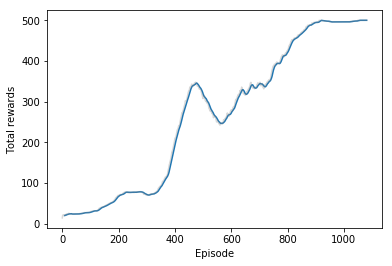

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

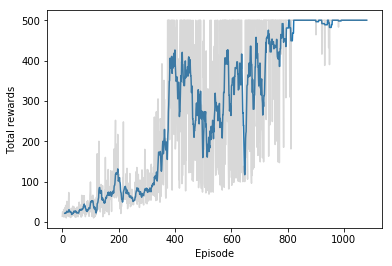

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [25]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
